In [77]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2, l1

In [79]:
data_dir = "data"

In [81]:
batch_size = 32
img_height = 180
img_width = 180

In [83]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12500 files belonging to 25 classes.
Using 10000 files for training.


In [84]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12500 files belonging to 25 classes.
Using 2500 files for validation.


In [87]:
class_names = train_ds.class_names
print(class_names)

['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'disposable_plastic_cutlery', 'food_waste', 'furniture', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans']


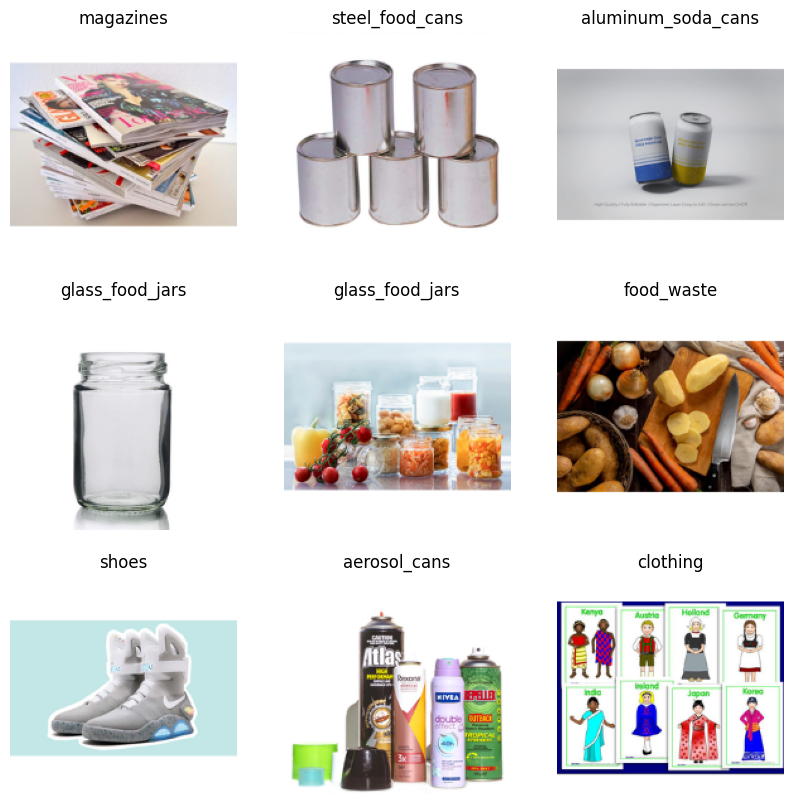

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [91]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [93]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [95]:
normalization_layer = layers.Rescaling(1./255)


In [97]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.004267278 1.0


In [127]:
data_augmentation = keras.Sequential(
  [
    layers.Input(shape=(img_height, img_width, 3)),  # Correctly define the input layer
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [198]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
    layers.Dropout(0.5),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
    layers.Dropout(0.5),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2(0.0001)),
    layers.Dropout(0.5),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [200]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [202]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_13 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 180, 180, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 25)                  │           3,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,991,865 (15.23 MB)

 Trainable params: 3,991,865 (15.23 MB)

 Non-trainable params: 0 (0.00 B)

In [204]:
# add early stopping for when val_loss does not improve for a set number of epoch
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 150ms/step - accuracy: 0.0472 - loss: 3.4621 - val_accuracy: 0.0964 - val_loss: 3.1870
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 149ms/step - accuracy: 0.0722 - loss: 3.1582 - val_accuracy: 0.0812 - val_loss: 3.1129
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.0989 - loss: 3.0780 - val_accuracy: 0.1708 - val_loss: 3.0863
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accuracy: 0.1408 - loss: 2.9355 - val_accuracy: 0.1676 - val_loss: 3.0248
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.1688 - loss: 2.8490 - val_accuracy: 0.1876 - val_loss: 2.9877
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.1788 - loss: 2.7488 - val_accuracy: 0.1472 - val_loss: 2.9981
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 148ms/step - accuracy: 0.2097 - loss: 2.7096 - val_accuracy: 0.1820 - val_loss: 2.9226
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 46s 147ms/step - accuracy: 0.2133 - loss: 2

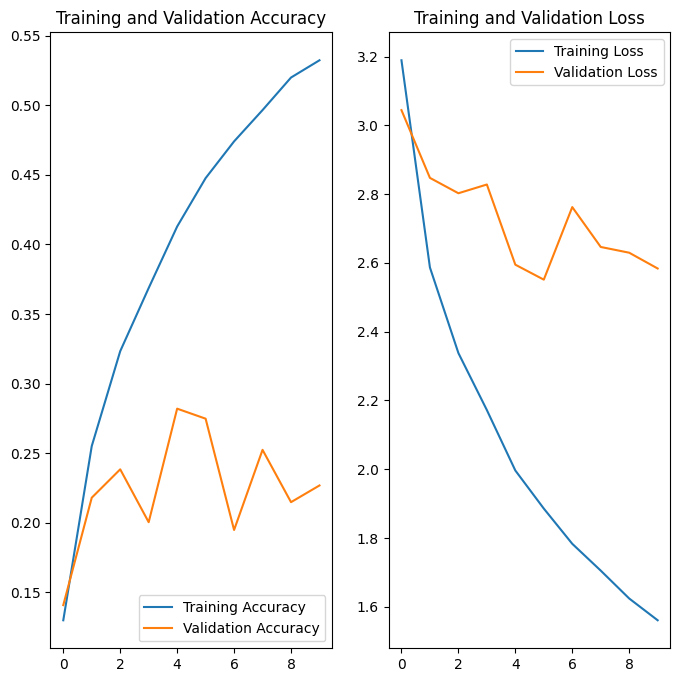

In [196]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [157]:
import cv2

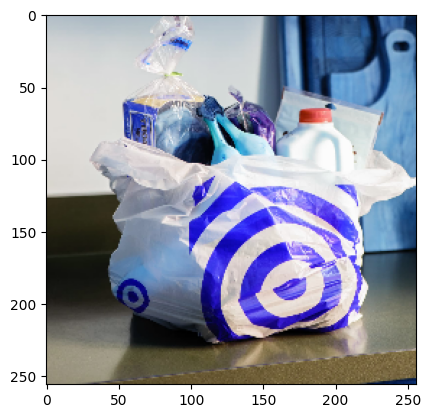

In [164]:
imgPath = cv2.imread('plastic-bag.png')
resize = tf.image.resize(imgPath, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [166]:
img = tf.keras.utils.load_img(
    'plastic-bag.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print("-------------------------------------------")

for i, class_name in enumerate(class_names):
    print(f"{class_name}: {score[i] * 100:.2f}% confidence")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
This image most likely belongs to clothing with a 7.35 percent confidence.
-------------------------------------------
aerosol_cans: 3.84% confidence
aluminum_food_cans: 3.82% confidence
aluminum_soda_cans: 3.90% confidence
cardboard_boxes: 3.81% confidence
cardboard_packaging: 3.86% confidence
clothing: 7.35% confidence
disposable_plastic_cutlery: 4.25% confidence
food_waste: 3.80% confidence
furniture: 3.81% confidence
glass_beverage_bottles: 3.81% confidence
glass_cosmetic_containers: 3.81% confidence
glass_food_jars: 3.81% confidence
magazines: 3.82% confidence
newspaper: 3.86% confidence
paper_cups: 3.82% confidence
plastic_cup_lids: 3.81% confidence
plastic_detergent_bottles: 3.81% confidence
plastic_food_containers: 3.80% confidence
plastic_shopping_bags: 4.33% confidence
plastic_soda_bottles: 3.82% confidence
plastic_straws: 3.81% confidence
plastic_trash_bags: 3.81% confidence
plastic_water_bottles: 3.81% confidence
shoes: 3.82% confidence